# Text Detection using Amazon Rekognition

***
This notebook provides a walkthrough of [object detection API](https://docs.aws.amazon.com/rekognition/latest/dg/labels.html) in Amazon Rekognition. You can quickly identify objects in your video and image libraries to catalog footage and photos for marketing, advertising, and media industry use cases.
***

# Initialize stuff

In [1]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [2]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [3]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

In [4]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.

bucketName = "aws-workshops-" + awsRegion

In [5]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and drwaw bounding boxes
# around recognized celebrities to show them here in the notebook.

!mkdir m1tmp
tempFolder = 'm1tmp/'

mkdir: cannot create directory ‘m1tmp’: File exists


# Detect text in image
***

In [6]:
imageName = "object-detection/nfl-player.jpg"

In [7]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to detect text in the image

In [8]:
# Call Amazon Rekognition to detect objects in the image
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectLabels.html

detectTextResponse = rekognition.detect_text(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

#### Review the raw JSON reponse from Rekognition

In [9]:
# Show JSON response returned by Rekognition Labels API (Object Detection)
# In the JSON response below, you will see Label, detected instances, confidence score and additional information.

display(detectTextResponse)

{'TextDetections': [{'DetectedText': 'PATRIOTS',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 89.93755340576172,
   'Geometry': {'BoundingBox': {'Width': 0.06402438879013062,
     'Height': 0.02981029823422432,
     'Left': 0.43140244483947754,
     'Top': 0.4878048896789551},
    'Polygon': [{'X': 0.43140244483947754, 'Y': 0.4878048896789551},
     {'X': 0.49542683362960815, 'Y': 0.4878048896789551},
     {'X': 0.49542683362960815, 'Y': 0.5176151990890503},
     {'X': 0.43140244483947754, 'Y': 0.5176151990890503}]}},
  {'DetectedText': '12',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 99.25,
   'Geometry': {'BoundingBox': {'Width': 0.17567528784275055,
     'Height': 0.33155837655067444,
     'Left': 0.38259199261665344,
     'Top': 0.5356987714767456},
    'Polygon': [{'X': 0.38259199261665344, 'Y': 0.5356987714767456},
     {'X': 0.5582672953605652, 'Y': 0.5310761332511902},
     {'X': 0.5610277652740479, 'Y': 0.862634539604187},
     {'X': 0.3853524923324585, 'Y': 0.86725717

#### Display list of detected words and lines

In [10]:
for textDetection in detectTextResponse["TextDetections"]:
    print("- {}".format(textDetection["DetectedText"]))
    print("  - {}".format(textDetection["Type"]))

- PATRIOTS
  - LINE
- 12
  - LINE
- 12
  - WORD
- PATRIOTS
  - WORD


#### Show image with bounding boxes around detected objects

In [11]:
# Define a function that will display image with bounded boxes around recognized celebrites
# We will call this function in next step
  
def drawBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255,255,255),(255,255,255),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(sourceImage)
    s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
       imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)

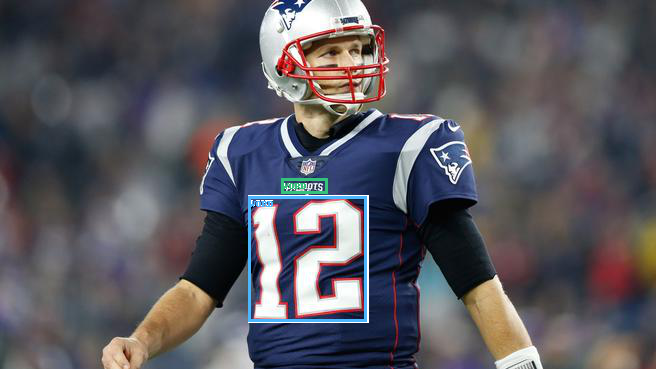

In [12]:
# Extract bounding box information from JSON response above and display image with bounding boxes around objects.

boxes = []
textDetections = detectTextResponse['TextDetections']
for textDetection in textDetections:
        boxes.append ((textDetection['Type'], textDetection["Geometry"]['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)

## Overlapping objects/text in Images
***

In [13]:
detectLabelsResponse = rekognition.detect_labels(
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    }
)

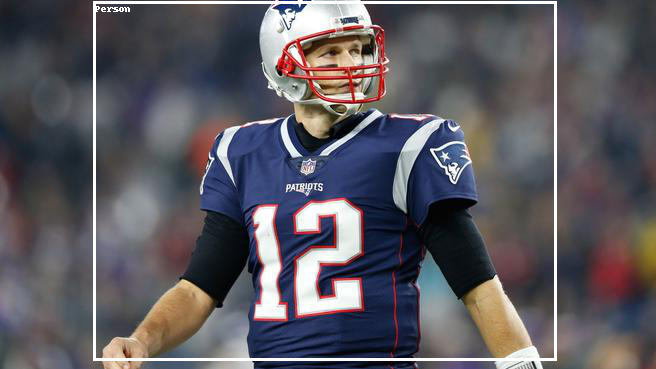

In [14]:
boxes = []
objects = detectLabelsResponse['Labels']
for obj in objects:
    if(obj["Name"] == "Person"):
        for einstance in obj["Instances"]:
            boxes.append ((obj['Name'], einstance['BoundingBox']))
    
drawBoundingBoxes(imageName, boxes)


In [15]:
s3Resource = boto3.resource('s3')
bucket = s3Resource.Bucket(bucketName)
iojb = bucket.Object(imageName)
response = iojb.get()
file_stream = response['Body']
im = Image.open(file_stream)
imageWidth, imageHeight = im.size


In [16]:
# Find overlapping text on person to identify player

***
### References
- https://docs.aws.amazon.com/rekognition/latest/dg/API_DetectText.html

***

You have successfully used Amazon Rekognition to identify celebrities in images an videos. In the next module, Recognize Custom Celebrities, you will learn how to recognize your custom celebrities in the images and videos.